##Login to Hugging Face

In [1]:
from huggingface_hub import notebook_login
notebook_login()

## Load the Model

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    safety_checker=None  # Disable for experimentation
)
pipe = pipe.to(device)
pipe.enable_attention_slicing()  # Saves VRAM

print("✅ Model loaded successfully!")

## Define the Image Generator Function

In [3]:
import time
from PIL import Image

def generate_image(prompt, negative_prompt="", num_steps=50, guidance_scale=7.5, seed=42):
    """
    Generate an image and return image + metadata.

    Args:
        prompt          : The text prompt
        negative_prompt : Things to avoid in the image
        num_steps       : Denoising steps (more = better quality, slower)
        guidance_scale  : How strictly to follow prompt (7-12 is ideal)
        seed            : For reproducibility

    Returns:
        image, metadata dict
    """
    generator = torch.Generator(device=device).manual_seed(seed)

    start_time = time.time()

    result = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt if negative_prompt else None,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
        generator=generator,
        height=512,
        width=512,
    )

    elapsed = round(time.time() - start_time, 2)
    image = result.images[0]

    metadata = {
        "prompt": prompt,
        "negative_prompt": negative_prompt,
        "num_steps": num_steps,
        "guidance_scale": guidance_scale,
        "seed": seed,
        "inference_time_sec": elapsed,
        "device": device,
    }

    return image, metadata

## Define 3 Prompt Variants

In [7]:
SUBJECT = "a lone astronaut on Mars"

# Improved composition control
COMPOSITION = (
    "((full body shot)), "
    "((perfectly centered)), "
    "symmetrical composition, "
    "standing facing camera, "
    "mid distance shot, "
    "eye level camera, "
    "50mm lens"
)

prompts = {
    "basic": {
        "prompt": (
            f"{SUBJECT}, "
            f"{COMPOSITION}, "
            "photorealistic, sharp focus, realistic Mars terrain"
        ),
        "negative_prompt": (
            "wide angle, fisheye, extreme perspective, cropped, cut off, "
            "blurry, low quality, cartoon, anime, painting, distorted, "
            "extra limbs, bad anatomy, watermark, text"
        ),
        "label": "1. Basic Prompt (Improved Composition)"
    },

    "detailed": {
    "prompt": (
        "((a lone astronaut on Mars:1.6)), "
        "((full body shot:1.3)), "
        "((astronaut clearly visible:1.4)), "
        "standing facing camera, "
        "center of frame, "
        "symmetrical composition, "
        "medium long shot, "
        "50mm lens, "
        "red dusty Mars terrain, "
        "golden hour sunset lighting, "
        "realistic shadows, "
        "ultra realistic spacesuit details, "
        "sharp focus, depth of field"
    ),
    "negative_prompt": (
        "empty landscape, no person, no astronaut, "
        "tiny subject, far away, wide landscape, "
        "fisheye, ultra wide, cropped body, "
        "blurry, low quality, cartoon, anime, painting, distorted, "
        "extra limbs, bad anatomy, watermark"
    ),
    "label": "2. Detailed Prompt (Astronaut Forced Visible)"
    },

    "negative": {
        "prompt": (
            f"(({SUBJECT}:1.4)), "
            "((full body shot:1.3)), "
            "((center of frame:1.5)), "
            "symmetrical framing, "
            "standing upright, "
            "medium long shot, "
            "camera 10 meters away, "
            "50mm lens, "
            "photorealistic, "
            "realistic Mars terrain, "
            "golden hour sunlight, "
            "sharp focus, high detail"
        ),
        "negative_prompt": (
            "wide landscape, extreme wide angle, fisheye, tiny subject, "
            "cropped, partial body, cut off head, "
            "blurry, distorted, extra limbs, "
            "cartoon, anime, painting, watermark, text"
        ),
        "label": "3. Detailed + Strong Negative (Highly Controlled)"
    }
}

## Generate All 3 Images + Log Results

In [8]:
import os
import json

os.makedirs("generated_images", exist_ok=True)

results = {}

for key, config in prompts.items():
    print(f"\n🚀 Generating: {config['label']}...")
    print(f"   Prompt: {config['prompt'][:80]}...")

    image, metadata = generate_image(
        prompt=config["prompt"],
        negative_prompt=config["negative_prompt"],
        num_steps=50,
        guidance_scale=7.5,
        seed=42
    )

    # Save image
    filename = f"generated_images/{key}_result.png"
    image.save(filename)
    metadata["saved_to"] = filename

    results[key] = {"image": image, "metadata": metadata}

    print(f"   ✅ Done in {metadata['inference_time_sec']}s → saved to {filename}")

print("\n✅ All images generated!")


🚀 Generating: 1. Basic Prompt (Improved Composition)...
   Prompt: a lone astronaut on Mars, ((full body shot)), ((perfectly centered)), symmetrica...


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['depth of field']


   ✅ Done in 12.08s → saved to generated_images/basic_result.png

🚀 Generating: 2. Detailed Prompt (Astronaut Forced Visible)...
   Prompt: ((a lone astronaut on Mars:1.6)), ((full body shot:1.3)), ((astronaut clearly vi...


  0%|          | 0/50 [00:00<?, ?it/s]

   ✅ Done in 12.86s → saved to generated_images/detailed_result.png

🚀 Generating: 3. Detailed + Strong Negative (Highly Controlled)...
   Prompt: ((a lone astronaut on Mars:1.4)), ((full body shot:1.3)), ((center of frame:1.5)...


  0%|          | 0/50 [00:00<?, ?it/s]

   ✅ Done in 13.59s → saved to generated_images/negative_result.png

✅ All images generated!


## Compare All 3 Side-by-Side

/tmp/ipython-input-546/3464411973.py:58: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=4.0)
/tmp/ipython-input-546/3464411973.py:58: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=4.0)
/tmp/ipython-input-546/3464411973.py:59: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.savefig("generated_images/comparison_vertical.png", dpi=150,
/tmp/ipython-input-546/3464411973.py:59: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("generated_images/comparison_vertical.png", dpi=150,


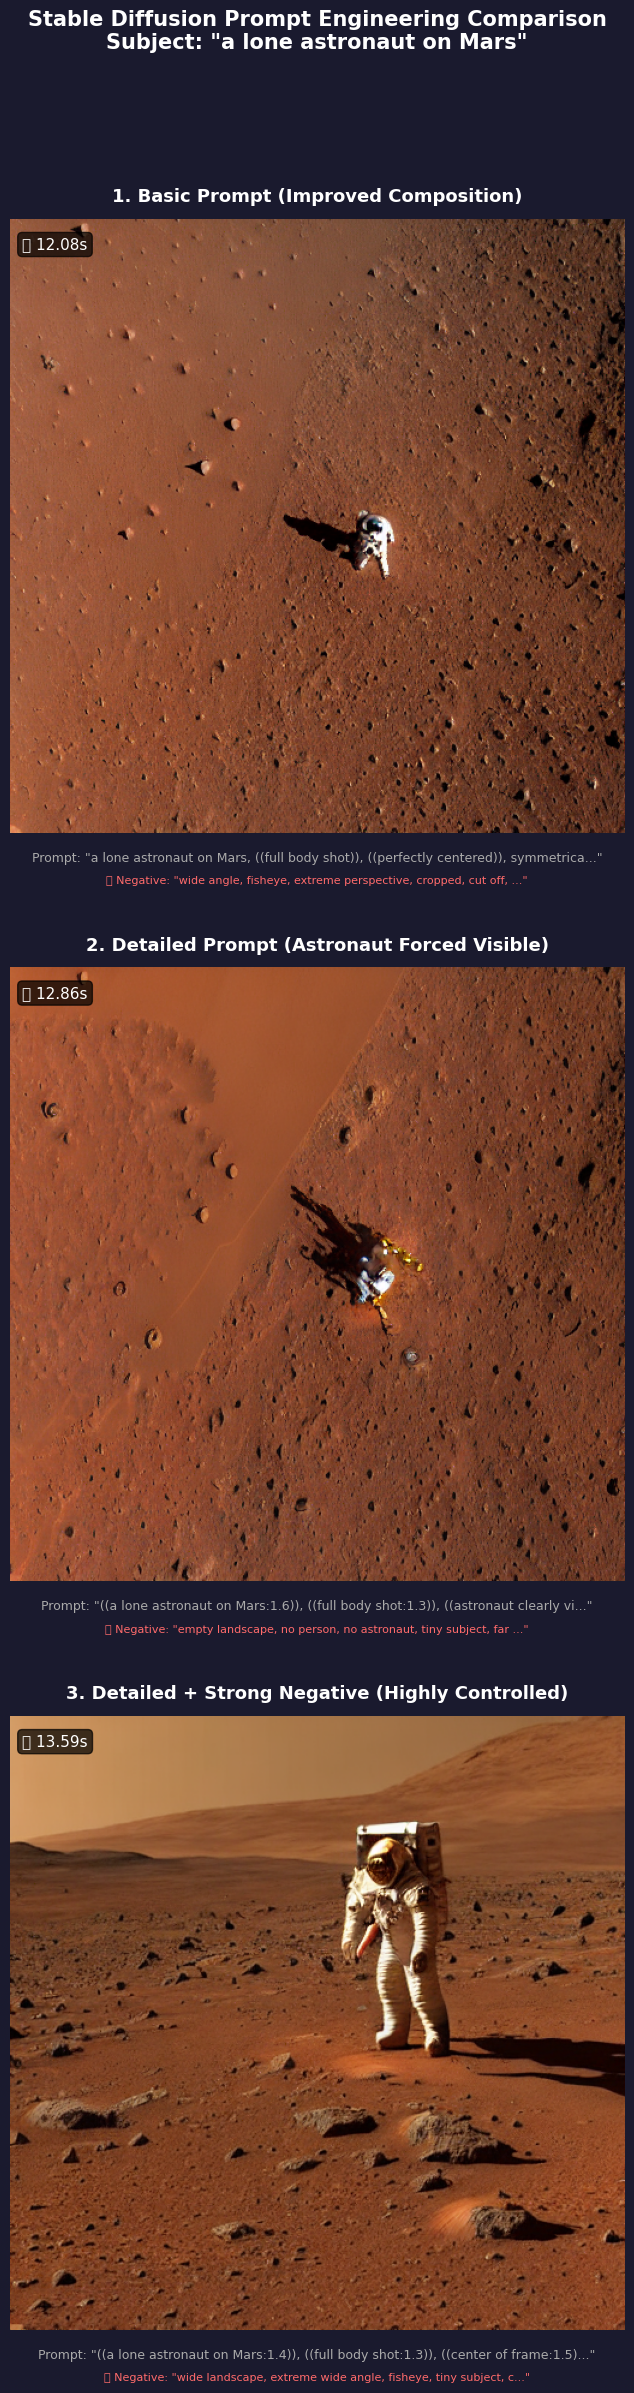

📊 Vertical comparison saved → generated_images/comparison_vertical.png


In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 24))  # 3 rows, 1 column
fig.patch.set_facecolor('#1a1a2e')

border_colors = ["#e94560", "#00b4d8", "#06d6a0"]

for idx, (key, config) in enumerate(prompts.items()):
    ax = axes[idx]
    data = results[key]

    ax.imshow(data["image"])
    ax.set_title(
        config["label"],
        color="white", fontsize=13, fontweight="bold", pad=12
    )
    ax.axis("off")

    # Add colored border
    for spine in ax.spines.values():
        spine.set_edgecolor(border_colors[idx])
        spine.set_linewidth(4)
    ax.set_frame_on(True)

    # Inference time badge (top-left)
    ax.text(
        0.02, 0.97,
        f"⏱ {data['metadata']['inference_time_sec']}s",
        transform=ax.transAxes,
        color="white", fontsize=11, verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.7)
    )

    # Prompt preview badge (bottom)
    short_prompt = config["prompt"][:80] + "..." if len(config["prompt"]) > 80 else config["prompt"]
    ax.text(
        0.5, -0.03,
        f'Prompt: "{short_prompt}"',
        transform=ax.transAxes,
        color="#aaaaaa", fontsize=9, ha="center", va="top",
        wrap=True
    )

    # Negative prompt label if present
    if config["negative_prompt"]:
        ax.text(
            0.5, -0.07,
            f'❌ Negative: "{config["negative_prompt"][:60]}..."',
            transform=ax.transAxes,
            color="#ff6b6b", fontsize=8, ha="center", va="top"
        )

plt.suptitle(
    f'Stable Diffusion Prompt Engineering Comparison\nSubject: "{SUBJECT}"',
    color="white", fontsize=15, fontweight="bold", y=1.01
)

plt.tight_layout(pad=4.0)
plt.savefig("generated_images/comparison_vertical.png", dpi=150,
            bbox_inches="tight", facecolor='#1a1a2e')
plt.show()
print("📊 Vertical comparison saved → generated_images/comparison_vertical.png")

## Print Full Inference Log

In [10]:
print("\n" + "="*65)
print("📋  INFERENCE LOG")
print("="*65)

for key, data in results.items():
    m = data["metadata"]
    print(f"\n🔹 {prompts[key]['label']}")
    print(f"   Prompt          : {m['prompt'][:70]}...")
    print(f"   Negative Prompt : {m['negative_prompt'][:60] or 'None'}")
    print(f"   Steps           : {m['num_steps']}")
    print(f"   Guidance Scale  : {m['guidance_scale']}")
    print(f"   Seed            : {m['seed']}")
    print(f"   Inference Time  : {m['inference_time_sec']} seconds")
    print(f"   Saved To        : {m['saved_to']}")

# Save log as JSON
with open("generated_images/inference_log.json", "w") as f:
    log_data = {k: v["metadata"] for k, v in results.items()}
    json.dump(log_data, f, indent=2)

print("\n📁 Full log saved → generated_images/inference_log.json")


📋  INFERENCE LOG

🔹 1. Basic Prompt (Improved Composition)
   Prompt          : a lone astronaut on Mars, ((full body shot)), ((perfectly centered)), ...
   Negative Prompt : wide angle, fisheye, extreme perspective, cropped, cut off, 
   Steps           : 50
   Guidance Scale  : 7.5
   Seed            : 42
   Inference Time  : 12.08 seconds
   Saved To        : generated_images/basic_result.png

🔹 2. Detailed Prompt (Astronaut Forced Visible)
   Prompt          : ((a lone astronaut on Mars:1.6)), ((full body shot:1.3)), ((astronaut ...
   Negative Prompt : empty landscape, no person, no astronaut, tiny subject, far 
   Steps           : 50
   Guidance Scale  : 7.5
   Seed            : 42
   Inference Time  : 12.86 seconds
   Saved To        : generated_images/detailed_result.png

🔹 3. Detailed + Strong Negative (Highly Controlled)
   Prompt          : ((a lone astronaut on Mars:1.4)), ((full body shot:1.3)), ((center of ...
   Negative Prompt : wide landscape, extreme wide angle, fis